In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../../../")

import yaml
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import numpy as np
import scanpy as sc
from scipy import sparse
from matplotlib.colors import LinearSegmentedColormap

from utils.utils import *
from utils.plotting import *
from utils.markers import *

sc.settings.verbosity = 0
sc.settings._vector_friendly = True
import matplotlib as mpl
from matplotlib import font_manager
font_dirs = "/usr/share/fonts/truetype/msttcorefonts/"
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "arial"
plt.rcParams['font.size'] = 12
# sc.set_figure_params(transparent=True)

Global seed set to 0
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


## Load data

In [2]:
mudata = md.read_h5mu("data/anca/ustekinumab/ANCA_4PK4PB_ustekinumab_clean.h5mu")
mod_rna = mudata.mod["rna"]
mod_cite = mudata.mod["cite"]

mudata_cd4 = md.read_h5mu(
    "data/anca/ustekinumab/ANCA_4PK4PB_ustekinumab_subset_clean.h5mu"
)
mod_rna_cd4 = mudata_cd4.mod["rna"]
mod_cite_cd4 = mudata_cd4.mod["cite"]

mudata_cd8 = md.read_h5mu(
    "data/anca/ustekinumab/R_ANCA_4PK4PB_ustekinumab_cd8emrm_annotated.h5mu"
)
mod_rna_cd8 = mudata_cd8.mod["rna"]
mod_cite_cd8 = mudata_cd8.mod["cite"]

In [33]:
mod_rna.shape

(34810, 38224)

## Processing

In [4]:
def remove_duplicates(list_):
    seen = set()
    list_ = [x for x in list_ if not (x in seen or seen.add(x))]
    return list_

In [5]:
log_normalize(mod_rna)
log_normalize(mod_rna_cd4)
log_normalize(mod_rna_cd8)

protein_clr(mod_cite)
protein_clr(mod_cite_cd4)
protein_clr(mod_cite_cd8)

## Quality control overview

In [6]:
mapping = {
    "CD4_EM/RM": "CD4+ Teff",
    "CD8_EM/RM": "CD8+ Teff",
    "CD4_CM/EM": "CD4+ Tcm/Tem",
    "CD4_CM": "CD4+ Tcm",
    "CD4_Naive": "CD4+ naive",
    "CD8_Naive": "CD8+ naive",
    "Treg": "Treg",
    "MAIT": "MAIT/gdT",
    "CD4_CTL": "CD4+ CTL",
    "CD8_CTL": "NKT",
    "NKT/gdT": "NKT",
    "NKT": "NKT",
    "Prolif": "Prolif",
}
mod_rna.obs["cell_type_v1"] = (
    mod_rna.obs["cell_type"].astype(str).replace(mapping).astype("category")
)

order = [
    "CD4+ Teff",
    "CD8+ Teff",
    "CD4+ Tcm/Tem",
    "CD4+ Tcm",
    "CD4+ naive",
    "CD8+ naive",
    "CD4+ CTL",
    "Treg",
    "MAIT/gdT",
    "NKT",
    "Prolif",
]

mod_rna.obs["cell_type_v1"] = mod_rna.obs["cell_type_v1"].cat.reorder_categories(order)

In [7]:
celltype_col = "cell_type"
celltype_col = "cell_type_v1"

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

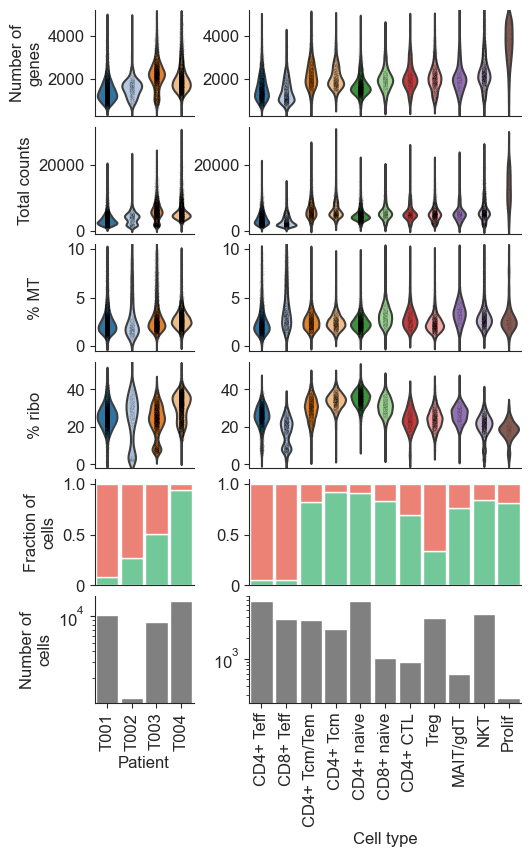

In [8]:
plot_qc(
    mod_rna,
    cell_type_key=celltype_col,
    figsize=(5.5, 9),
    wspace=0.3,
    save_path="figures/supp/ustekinumab_qc.pdf",
    # log_scale=False,
)

## UMAP

In [9]:
# dict(
#     zip(mod_rna.obs[celltype_col].unique().tolist(), mod_rna.uns["cell_type_v1_colors"])
# )
color_map = {
    "CD4+ Teff": "#d62728",
    "CD8+ Teff": "#aa40fc",
    "CD4+ Tcm/Tem": "#1f77b4",
    "CD4+ Tcm": "#8c564b",
    "CD8+ naive": "#17becf",
    "CD4+ naive": "#e377c2",
    "CD4+ CTL": "#aec7e8",
    "Treg": "#b5bd61",
    "MAIT/gdT": "#ffbb78",
    "NKT": "#279e68",
    "Prolif": "#ff7f0e",
}
colors = [color_map[k] for k in order]

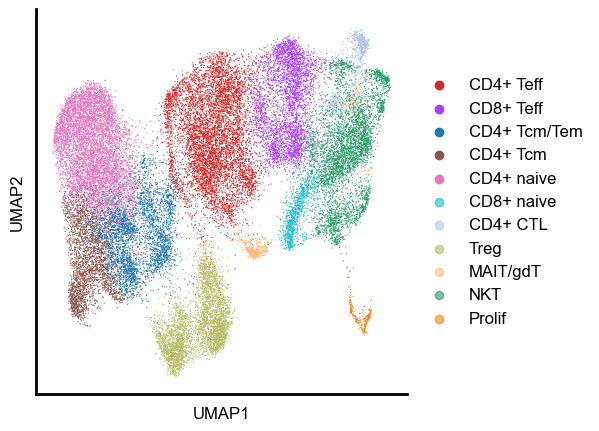

In [10]:
mod_rna.obs[celltype_col] = pd.Categorical(
    mod_rna.obs[celltype_col], categories=order, ordered=True
)
plot_umap(
    mod_rna,
    color=celltype_col,
    palette=colors,
    figsize=(5.5, 5),
    title="",
    size=3,
    axes_fraction=1.0,
    save_path="figures/supp/ustekinumab_umap.pdf",
)

## Patient distribution

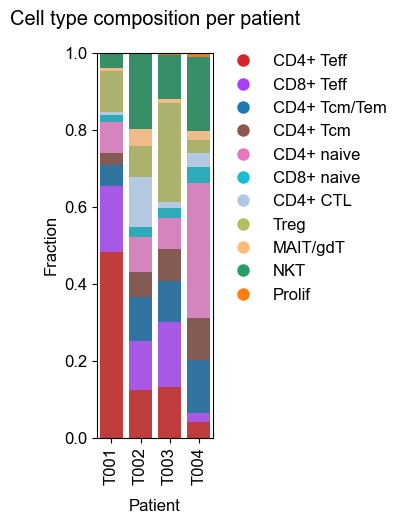

In [47]:
colors = [color_map[x] for x in order]
plot_cluster_composition_per_sample(
    mod_rna,
    colors,
    celltype_col,
    order=order,
    save_path="figures/supp/ustekinumab_celltype_comp_per_patient.pdf",
    figsize=(1.5, 5),
    title_pad=20,
)

## Tissue composition

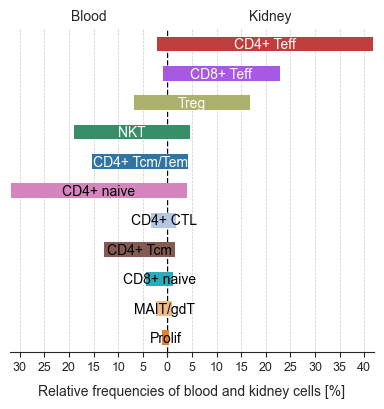

In [14]:
plot_tissue_compostion(
    mod_rna,
    color_map,
    celltype_key=celltype_col,
    tissue_key="tissue",
    # label_order=celltypes_to_keep,
    use_rel_values=True,
    figsize=(4, 4),
    num_white=5,
    save_path="figures/supp/ustekinumab_tissue_composition_full.pdf",
)

## Gene scores

In [24]:
th1_genes = [
    "IFNG",
    "IL2",
    "TNF",
    "LTA",
    "CSF2",
    "IL18",
]
th2_genes = [
    "IL4",
    "IL5",
    "IL9",
    "IL13",
    # "IL10",
    # "IL21",
    # "IL6",
]
th17_genes = ["IL17A", "IL17F", "IL22", "IL26"]

gene_list = th1_genes + th2_genes + th17_genes

mod_rna.X = mod_rna.layers["scaled"].copy()

cytokine_markers = gene_list
sc.tl.score_genes(
    mod_rna,
    gene_list=cytokine_markers,
    score_name="cytokine_score",
    ctrl_size=50,
    use_raw=False,
)
sc.tl.score_genes(
    mod_rna,
    gene_list=th1_genes,
    score_name="type1_score",
    ctrl_size=50,
    use_raw=False,
)
sc.tl.score_genes(
    mod_rna,
    gene_list=th2_genes,
    score_name="type2_score",
    ctrl_size=50,
    use_raw=False,
)
sc.tl.score_genes(
    mod_rna,
    gene_list=th17_genes,
    score_name="type3_score",
    ctrl_size=50,
    use_raw=False,
)
mod_rna.X = mod_rna.layers["log1p"].copy()

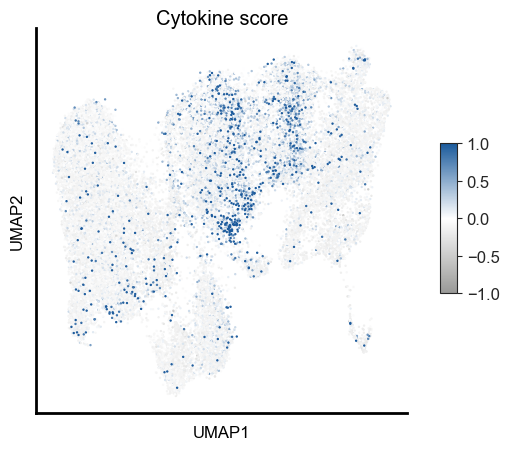

In [25]:
# Define the colors for the colormap (light grey to blue)
colors = [
    # "#E6E6E3",
    "#999997",
    # "lightgrey",
    "white",
    [0.10572856593617842, 0.35432525951557103, 0.6110726643598616],
]
cmap_name = "custom_lightgrey_blue"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

plot_scores(
    mod_rna,
    figsize=(5.5, 5),
    score="cytokine_score",
    # title=None,
    title="Cytokine score",
    cmap=custom_cmap,
    save_path="figures/supp/ustekinumab_cytokine_score.pdf",
)

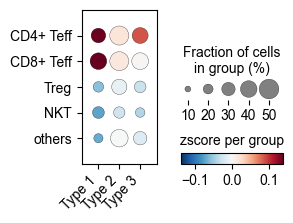

In [26]:
celltypes_to_keep = ["CD4+ Teff", "CD8+ Teff", "Treg", "NKT"]
replacements = {
    x: (x if x in celltypes_to_keep else "others")
    for x in mod_rna.obs[celltype_col].unique()
}
mod_rna.obs["cell_type_agg"] = mod_rna.obs[celltype_col].replace(replacements)
color_map_agg = {k: color_map[k] for k in celltypes_to_keep}
color_map_agg["others"] = "lightgrey"

order = ["CD4+ Teff", "CD8+ Teff", "Treg", "NKT", "others"]
mod_rna.obs.cell_type_agg = pd.Categorical(
    mod_rna.obs.cell_type_agg, categories=order, ordered=True
)
fig = sc.pl.dotplot(
    mod_rna,
    var_names=["type1_score", "type2_score", "type3_score"],
    groupby="cell_type_agg",
    color_map="RdBu_r",
    vmin=-0.14,
    vmax=0.14,
    # return_fig=True,
    show=False,
    # title="",
    # size_title=0,
    figsize=(2.6, 2.0),
    colorbar_title="zscore per group",
)
ax = fig["mainplot_ax"]
ax.set_xticklabels(["Type 1", "Type 2", "Type 3"], rotation=45, ha="right")
plt.savefig(
    "figures/supp/ustekinumab_cytokine_score_dotplot.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

## Marker dotplots

In [48]:
marker_df = pd.read_excel("data/markers/T cell markers.xlsx")
marker_df = marker_df.set_index("Cell type")

# extract positive markers
marker_db = {}
for index, row in marker_df.iterrows():
    pos_markers_1 = (
        row["positive markers 1"].replace(" ", "").split(",")
        if row["positive markers 1"] is not np.nan
        else []
    )
    pos_markers_2 = (
        row["positive markers 2"].replace(" ", "").split(",")
        if row["positive markers 2"] is not np.nan
        else []
    )
    marker_db[index] = list(set(pos_markers_1 + pos_markers_2))

marker_plotter = MarkerPlotter(
    mod_rna, mod_cite, marker_db, cluster_key="cell_type_fine"
)

### Overall

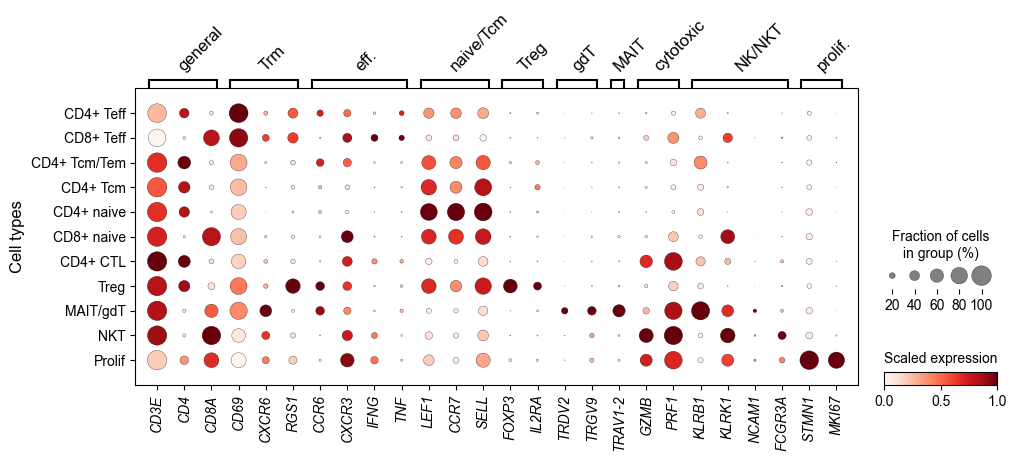

In [59]:
celltype_col = "cell_type_v1"
seen = set()
order = [x for x in order if not (x in seen or seen.add(x))]
# print(order)
dotplot_markers(
    mod_rna,
    celltype_col="cell_type_v1",
    celltype_order=order,
    scaled=False,
    marker_dict=get_markers_tcell(),
    rotation=45,
    save_path="figures/supp/ustekinumab_tcell_markers.pdf",
)

In [20]:
# mod_cite.obs["cell_type_v1"] = mod_rna.obs["cell_type_v1"]
# marker_dict_prot = {
#     "Trm": ["CD69"],
#     "eff": [
#         "CXCR3",
#         "CCR6",
#     ],
#     "naive": [
#         "CD45RA",
#     ],
#     "Tcm": [
#         "CCR7",
#         "CD27",
#         "CD45RO",
#     ],
#     "Treg": [
#         "CD25",
#     ],
#     "gdT": [
#         "TCRVd2",
#         # "TCRVg9",
#         # "TCRgd",
#     ],
#     "MAIT": [
#         "TCRVa7.2",
#     ],
#     "NK/NKT": [
#         "NKG2D",
#         # "NKp30",
#         # "NKp44",
#         "NKp46",
#     ],
# }
# fig, ax = plt.subplots(figsize=(6, 5))
# fig = sc.pl.dotplot(
#     mod_cite,
#     var_names=marker_dict_prot,
#     groupby="cell_type_v1",
#     dendrogram=False,
#     ax=ax,
#     # color_map="RdBu_r",
#     color_map="Reds",
#     standard_scale="var",
#     colorbar_title="Scaled expression",
#     # vmin=-1,
#     # vmax=1,
# )

### CD4 subset

In [50]:
cmap_cd4 = {
    "Th17": "#7B1717",
    "Th1": "#A91F1F",
    "Th1-like": "#D62728",
    "Tfh": "#E0B093",
    # "Tc1-like": "#D2D2D2",
}
labels_cd4 = [key for key in cmap_cd4.keys()]

In [51]:
cd4_mapping = {
    "other CD4+ EM": "Th1-like",
    "TH1-like CD4+ EM": "Th1-like",
    "TRM17": "Th17",
    "TFH": "Tfh",
    "TRM1": "Th1",
}
colors = [cmap_cd4[x] for x in labels_cd4]
orig_col = mod_rna_cd4.obs["cell_type_fine"].copy()
mod_rna_cd4.obs["cell_type_fine"] = mod_rna_cd4.obs["cell_type_fine"].replace(
    cd4_mapping
)
mod_rna_cd4.obs["cell_type_umap"] = pd.Categorical(
    mod_rna_cd4.obs["cell_type_fine"], categories=labels_cd4, ordered=True
)

# celltype_order = ["Th17", "Th1", "Th1-like", "Tc1-like", "Tfh"]
mod_rna_cd4.obs["cell_type_fine"] = pd.Categorical(
    mod_rna_cd4.obs["cell_type_fine"], categories=labels_cd4, ordered=True
)

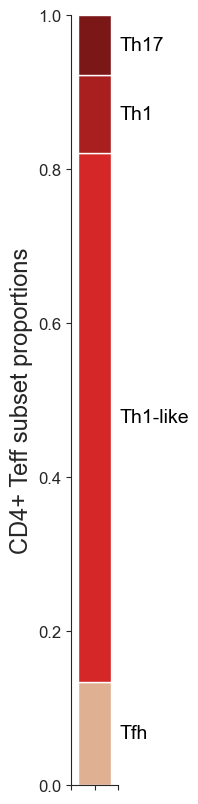

In [52]:
plot_single_stacked_bar(
    mod_rna_cd4,
    labels_cd4,
    cmap_cd4,
    "cell_type_fine",
    save_path="figures/supp/ustekinumab_cd4_stacked_bar.pdf",
    ylabel="CD4+ Teff subset proportions",
)

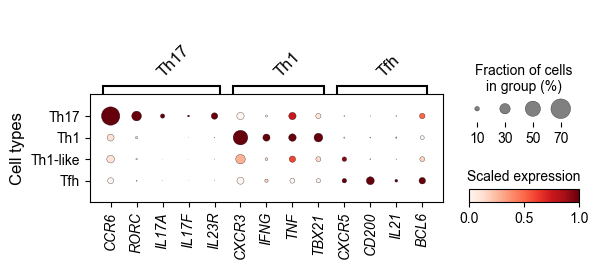

In [53]:
marker_dict_cd4 = {
    # "General": ["CD3D", "CD3E", "CD3G", "CD4", "CD8A", "CD8B"],
    "Th17": ["CCR6", "IL17A", "IL17F", "IL23R", "IL22"],
    "Th1": ["CXCR3", "IFNG", "TNF", "TBX21"],
    "Tfh": ["CXCR5", "CD200", "IL21", "BCL6"],
}
# labels_cd4 = ["Th1", "Th1-like", "Th17", "Tfh"]

markers = get_markers_cd4(mod_rna_cd4)
del markers["general"]

dotplot_markers(
    mod_rna_cd4,
    celltype_col="cell_type_fine",
    celltype_order=labels_cd4,
    scaled=False,
    marker_dict=markers,
    figsize=(6, 3),
    rotation=45,
    save_path="figures/supp/ustekinumab_cd4_markers.pdf",
)

In [25]:
# mod_cite_cd4.obs["cell_type_fine"] = mod_rna_cd4.obs["cell_type_fine"]
# mod_cite_cd4.obsm["X_umap"] = mod_rna_cd4.obsm["X_umap"]
# marker_dict_cd4_prot = {
#     # "General": ["CD3D", "CD3E", "CD3G", "CD4", "CD8A", "CD8B"],
#     "Th17": ["CCR6"],
#     "Th1": ["CXCR3"],
#     "Tfh": ["CXCR5"],
# }
# celltype_order = ["Th17", "Th1", "Th1-like", "Tfh"]
# mod_cite_cd4.obs["cell_type_fine"] = pd.Categorical(
#     mod_cite_cd4.obs["cell_type_fine"], categories=celltype_order, ordered=True
# )

# mod_cite_cd4.X = mod_cite_cd4.layers["clr"].copy()
# fig, ax = plt.subplots(figsize=(5, 3))
# fig = sc.pl.dotplot(
#     mod_cite_cd4,
#     var_names=marker_dict_cd4_prot,
#     groupby="cell_type_fine",
#     dendrogram=False,
#     ax=ax,
#     color_map="Reds",
#     # color_map="RdBu_r",
#     standard_scale="var",
#     # vmin=-0.3,
#     # vmax=0.3,
# )

### CD8 subset

In [54]:
mapping = {
    "CD8+ Tem/naive": "naive/Tcm",
    "CD8+ Tcm": "naive/Tcm",
}
mod_rna_cd8.obs["cell_type_fine_v1"] = mod_rna_cd8.obs["cell_type_fine"].replace(
    mapping
)

In [27]:
# plot_umap(mod_rna_cd8, color="cell_type_fine_v1", title="")

In [55]:
cmap_cd8 = {
    "Tc1": "#6600B4",
    # "Tc1-like": "#840AE2",
    "Tc1-like": "#A228FF",
    # "CD8+ Tem/naive": "#A228FF",
    # "CD8+ Tcm": "#CEB9DE",
    "naive/Tcm": "#CEB9DE",
    "NKT": "#D2D2D2",
}
labels = [key for key in cmap_cd8.keys()]

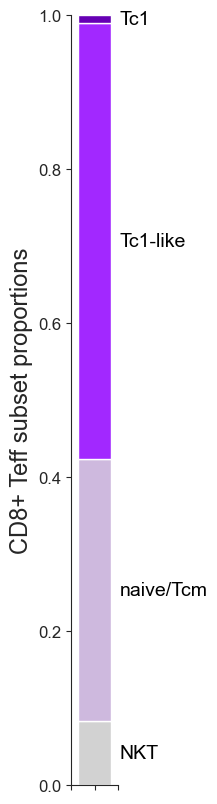

In [56]:
plot_single_stacked_bar(
    mod_rna_cd8,
    labels,
    cmap_cd8,
    "cell_type_fine_v1",
    save_path="figures/supp/ustekinumab_cd8_stacked_bar.pdf",
    ylabel="CD8+ Teff subset proportions",
)

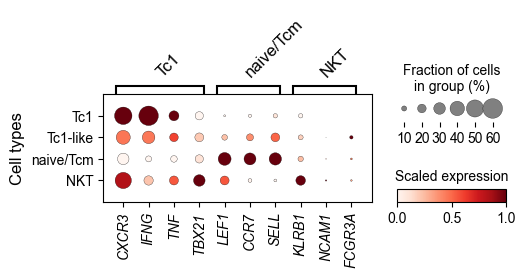

In [57]:
celltype_col_cd8 = "cell_type_fine_v1"

# celltype_order = ["Tc1", "Tc1-like", "Th1-like", "Tc17-like", "NKT/CTL"]
# celltype_order = ["Tc1", "Tc1-like", "CD8+ Tem/naive", "CD8+ Tcm", "NKT"]
celltype_order = ["Tc1", "Tc1-like", "naive/Tcm", "NKT"]


markers = get_markers_cd8(mod_rna_cd8)
del markers["general"]
del markers["Tc17"]
# markers["Tc17"] = markers["Tc17"][0:2]

dotplot_markers(
    mod_rna_cd8,
    celltype_col=celltype_col_cd8,
    celltype_order=celltype_order,
    scaled=False,
    marker_dict=markers,
    figsize=(5.5, 3),
    save_path="figures/supp/ustekinumab_cd8_markers.pdf",
)

In [ ]:
# mod_cite_cd8.obs[celltype_col_cd8] = mod_rna_cd8.obs[celltype_col_cd8]
# mod_cite_cd8.obsm["X_umap"] = mod_rna_cd8.obsm["X_umap"]
# marker_dict_cd8_prot = {
#     # "General": ["CD3D", "CD3E", "CD3G", "CD4", "CD8A", "CD8B"],
#     "Tc1": [
#         "CXCR3",
#         # "CCR5",
#         # "CD45RO",
#     ],
#     # "Tc17": ["CCR6"],
#     # "NKT": ["NCAM1", "KLRB1", "PRF1"],
#     "Tcm/naive": [
#         # "LEF1",
#         "CCR7",
#         "CD45RA",
#         "CD45RO",
#     ],
#     "NK/NKT": [
#         "NKG2D",
#         # "NKp30",
#         # "NKp44",
#         "NKp46",
#     ],
# }
# mod_cite_cd8.obs[celltype_col_cd8] = pd.Categorical(
#     mod_cite_cd8.obs[celltype_col_cd8], categories=celltype_order, ordered=True
# )

# fig, ax = plt.subplots(figsize=(5, 3))
# fig = sc.pl.dotplot(
#     mod_cite_cd8,
#     var_names=marker_dict_cd8_prot,
#     groupby=celltype_col_cd8,
#     dendrogram=False,
#     ax=ax,
#     color_map="Reds",
#     standard_scale="var",
# )